In [1]:
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import os, random, sys
from data_preprocessing import create_data_generators
import json
from sklearn.metrics import confusion_matrix
from test_resizing import resize_white, resize_black
from tensorflow.keras.utils import plot_model
from collections import Counter
import pandas as pd
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
# from analyse_results import load_image, generate_data_generators
# from analyse_results import load_model, print_confusion_matrix

In [2]:
# # model trained on original imgs
# RESULTS_FOLDER = "../saved_models/BEST_OF_THE_BEST/best_orginal_img_alllayers_v3/20190701_1148"
# resize = False

# model trained on resized imgs
RESULTS_FOLDER = "../saved_models/BEST_OF_THE_BEST/all_layers_trained_lhcbgpu_inceptionv3_RESIZEDIMGS/20190626_0944"
resize = True

# model trained on b&w imgs
# RESULTS_FOLDER = "../saved_models/july_tg/20190731_1323"
# resize = False


HYPERPARAMS_FILE =  RESULTS_FOLDER+ '/hyperparams.json'

with open(HYPERPARAMS_FILE, "r") as read_file:
    data = json.load(read_file)

HYPERPARAMS = data['hyperparameters'][0]
BATCHSIZE = HYPERPARAMS['BATCHSIZE']

#20190612_1048
if (os.getcwd() == '/home/kalkami/translearn'):
    #lhcpgpu1
    TRAIN_DIR = '/data/IntelliGate/kalkami/DATASETS/carsStanford_all/train'
    TEST_DIR = '/data/IntelliGate/kalkami/DATASETS/carsStanford_all/test'
    TRAIN_DIR_TST = TRAIN_DIR
    TEST_DIR_TST = TEST_DIR
    VALID_DIR_TST = TEST_DIR
else:
    #local
    TRAIN_DIR = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/train'
    TEST_DIR = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test'
    TRAIN_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/train'
    TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all_bw/test'
    TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test'
    VALID_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/CARS_GOOGLE_IMG/downloads'



In [3]:
def load_image(img_path, input_shape, resize = False):
    if resize:
        img, pth = resize_black(input_shape[1], img_path, print_oldsize=False)
    else:
        img = image.load_img(img_path, target_size=input_shape)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    return img_tensor


        
def generate_data_generators(input_shape):
    generator_train, generator_test = create_data_generators(input_shape, BATCHSIZE, 
                                                                TRAIN_DIR, TEST_DIR, 
                                                                save_augumented=None, 
                                                                plot_imgs = False)
    return generator_train, generator_test
        
        
def load_model(results_folder):
    # load json and create model
    json_file = open(results_folder + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(results_folder + "/weights.best.hdf5")
    input_shape = loaded_model.layers[0].output_shape[1:3]
    print("Loaded model from disk")
    return loaded_model, input_shape



def print_confusion_matrix(cls_pred, cls_test, class_names, cmap=plt.cm.Blues):
    '''Helper-function for printing confusion matrix'''
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    print("Confusion matrix:")
    # Print the confusion matrix as text.
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))
        
        
# def calc_acc(y_pred, y_test):
#     num_corrects = 0
#     for i in range(num_samples):
#         pred = y_pred[i]
#         test = y_test[i]
#         if pred == test:
#             num_corrects += 1
# return num_corrects / num_samples
        
    
        
def decode_predictions(preds, class_names, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

def predict(img_path, model, input_shape, class_names, correct_class, resize=False, show_imgs=True, top=5):
    img_array = load_image(img_path, input_shape, resize = resize)
    preds = model.predict(img_array)
    predictions = decode_predictions(preds, class_names, top=top)
    top1_pred = predictions[0][0]
    #print(predictions)
    #print(correct_class)
    if show_imgs:
        img_org = image.load_img(img_path)
        fig, axs = plt.subplots(1,2)
        axs[0].set_title(correct_class)
        axs[0].imshow(img_org)
        axs[1].set_title(str(top1_pred))
        axs[1].imshow(img_array[0])
        plt.show()
    return predictions
      
        

##------------------## All above should be transfer to the "analyse_results.py"    

def show_model_performance(loaded_model, generator_train, generator_test):
    steps_test = generator_test.n / BATCHSIZE
    steps_train = generator_test.n / BATCHSIZE
    cls_train = generator_train.classes
    cls_test = generator_test.classes
    class_names = list(generator_train.class_indices.keys())
    # Predict the classes for all images in the test-set
    y_pred = loaded_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    # plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred, cls_test, class_names)
    #result = loaded_model.evaluate_generator(generator_test, steps=steps_test)
    #result_train = loaded_model.evaluate_generator(generator_train, steps=steps_train)
    #print("Train-set classification accuracy: {0:.2%}".format(result_train[1]))
    #print("Test-set classification accuracy: {0:.2%}".format(result[1]))
        
def return_class_names_list(results_folder):
    class_names = []
    # open file and read the content in a list
    with open(results_folder+'/class_names.txt', 'r') as filehandle:  
        for line in filehandle:
            current_line = line[:-1]
            class_names.append(current_line)
    return class_names
        
def perform_pred(loaded_model, resize=False, car_class=None, img_pth=None, show_imgs=True):
    test_dir = TEST_DIR_TST
    results_folder = RESULTS_FOLDER
    
    if os.path.exists(results_folder+'/class_names.txt'):
        class_names = return_class_names_list(results_folder)

    else:
        generator_train, generator_test = generate_data_generators(results_folder, input_shape)
        class_names = list(generator_train.class_indices.keys())
        print(class_names)
        with open(results_folder+'/class_names.txt', 'w') as filehandle:  
            for listitem in class_names:
                filehandle.write('%s\n' % listitem)
                
    if car_class is None:
        car_class = random.choice(class_names)
    
    if img_pth is None: 
        # randomly select an image from defined class     
        test_dir_full = test_dir + '/' + car_class
        test_img = test_dir_full + '/' + random.choice(os.listdir(test_dir_full))
    else:
        test_img = img_pth
        
    
    input_shape = loaded_model.layers[0].output_shape[1:3]
    
          
    predictions = predict(test_img, loaded_model, input_shape, class_names, car_class, resize=resize, show_imgs=show_imgs)
    print(predictions)

In [4]:
loaded_model, input_shape=load_model(RESULTS_FOLDER)
generator_train, generator_test = generate_data_generators(input_shape)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
Found 8103 images belonging to 195 classes.
Found 8000 images belonging to 195 classes.


In [5]:
def take_make_from_classname(class_name):
    return class_name.split(' ', 1)[0]


def take_cartype_from_classname(class_name):
    elements = class_name.split()
    if class_name == 'Infiniti G Coupe IPL 2012':
        return elements[len(elements)-3]
    return elements[len(elements)-2]



def return_most_common_brands(class_names):
    brands_in_dataset = []
    brands_in_dataset_common = []
    cnt = Counter()
    for class_name in class_names:
        brands_in_dataset.append(take_make_from_classname(class_name))

    # for brand in Counter.brands_in_dataset:
    #     cnt[brand] += 1
    brands_in_dataset_common = Counter(brands_in_dataset).most_common(30)
    brands_in_dataset_common = [element[0] for element in brands_in_dataset_common]
    return brands_in_dataset_common

def return_car_types(class_names):
    car_types_in_dataset = []
    for class_name in class_names:
        car_types_in_dataset.append(take_cartype_from_classname(class_name))
    car_types_in_dataset_common = Counter(car_types_in_dataset).most_common(9)
    car_types_in_dataset_common = [element[0] for element in car_types_in_dataset_common]
    return car_types_in_dataset_common

def is_popular_brand(class_name, popular_brands):
    return take_make_from_classname(class_name) in popular_brands
       

def is_popular_type(class_name, popular_types):
    return take_cartype_from_classname(class_name) in popular_types

take_cartype_from_classname('Infiniti G Coupe IPL 2012')

'Coupe'

In [6]:
def plot_horizontal_bar(df, title='', fontsize=5, savepath='', many_data=True):
    if many_data:
        ax = df.plot.barh(color='#86bf91', zorder=2, width=0.85, figsize=(10,25))
    else:
        ax = df.plot.barh(color='#86bf91', zorder=2, width=0.85)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.ylabel('Odpowiedź sieci', fontsize=12, weight='bold')
    plt.xlabel('Wystąpienia', fontsize=12, weight='bold')
    plt.title(title, fontsize=14, weight='bold')
    if savepath != '':
        fig_name = title + '.png'
        fig_path = savepath + '/' + fig_name
        plt.savefig(fig_path)
    plt.show()

def plot_accuracy_for_all_classes(class_and_acc, title='', fontsize=5, savepath='', many_data=False):
    labels = list(class_and_acc.keys())
    values = list(class_and_acc.values())
    indexes = np.arange(len(labels))
    df = pd.DataFrame({'x' : labels , 'y' : values})
    df = df.sort_values('y',ascending = True)
    #df = df2[0:15]
    df = pd.DataFrame(list(zip(df['y'], df['x']))).set_index(1)
    # ax = df.plot.barh(color='#86bf91', zorder=2, width=0.85, figsize=(10,45))
    if many_data:
        ax = df.plot.barh(color='#86bf91', zorder=2, width=0.85, figsize=(10,25))
    else:
        ax = df.plot.barh(color='#86bf91', zorder=2, width=0.85)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.ylabel('Klasy', fontsize=12, weight='bold')
    plt.xlabel('Dokładność', fontsize=12, weight='bold')
    plt.title(title, fontsize=14, weight='bold')
    if savepath != '':
        fig_name = title + '.png'
        fig_path = savepath + '/' + fig_name
        plt.savefig(fig_path)
    plt.show()



def mostcommon_predictions(list_of_preds, title='', fontsize=5, savepath='', many_data=True):
    cnt = Counter()
    for pred in list_of_preds:
        cnt[pred] += 1
    labels = list(cnt.keys())
    values = list(cnt.values())
    indexes = np.arange(len(labels))
    df = pd.DataFrame({'x' : labels , 'y' : values})
    df = df.sort_values('y',ascending = True)
    df = pd.DataFrame(list(zip(df['y'], df['x']))).set_index(1)
    if many_data:
        ax = df.plot.barh(color='#86bf91', zorder=2, width=0.85, figsize=(10,25), fontsize = 16)
    else:
        ax = df.plot.barh(color='#86bf91', zorder=2, width=0.85, fontsize = 16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.ylabel('Odpowiedź sieci', fontsize=16, weight='bold')
    plt.xlabel('Wystąpienia', fontsize=16, weight='bold')
    plt.title(title, fontsize=14, weight='bold')
    if savepath != '':
        fig_name = title + '.png'
        fig_path = savepath + '/' + fig_name
        plt.savefig(fig_path)
    plt.show()
    return cnt

# # -*- coding: UTF-8 -*-
# import matplotlib.pyplot as plt
# # The slices will be ordered and plotted counter-clockwise.
# labels = [r'Rayos X (88.4 %)', r'RMN en solucion (10.6 %)', 
# r'Microscopia electronica (0.7 %)', r'Otros (0.3 %)']
# sizes = [88.4, 10.6, 0.7, 0.3]
# colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
# patches, texts = plt.pie(sizes, colors=colors, startangle=90)
# plt.legend(patches, labels, loc="best")
# # Set aspect ratio to be equal so that pie is drawn as a circle.
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

def plot_prediction_analysis_all(metrics):
    full_correct = metrics[0]
    correct_only_brand_or_type = metrics[2]
    full_incorrect = metrics[3]
    # Data to plot
    labels = 'Niepoprawne wskazania', 'Poprawne wskazania', 'Niepoprawne wskazania - ale zgadza się marka lub typ'
    sizes = [full_incorrect, full_correct, correct_only_brand_or_type]
    colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
    explode = (0, 0.1, 0)  # explode 1st slice
    # Plot
    patches = plt.pie(sizes, explode=explode, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=160)
    plt.legend(patches[0], labels, loc="best")
    plt.tight_layout()
    plt.axis('equal')
    plt.show()
    
def plot_prediction_analysis_brand(metrics):
    correct_brand = metrics[0] + metrics[1] # correct brand, doesn't matter if model
    incorrect_brand = (sum(metrics) - metrics[1]) - correct_brand
    # Data to plot
    labels = 'Prawidłowa marka', 'Nieprawidłowa marka'
    sizes = [correct_brand, incorrect_brand]
    colors = ['gold', 'lightskyblue']
    explode = (0.1, 0)  # explode 1st slice
    # Plot
    patches = plt.pie(sizes, explode=explode, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=160)
    plt.legend(patches[0], labels, loc="best")
    plt.tight_layout()
    plt.axis('equal')
    plt.show()
    
#plot_prediction_analysis_all([30,13,8,9])

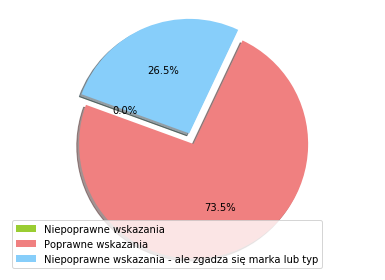

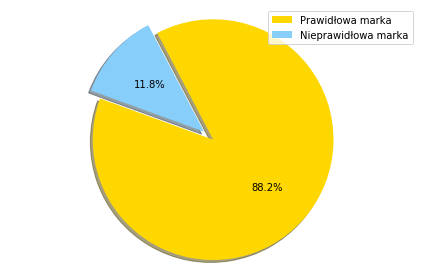

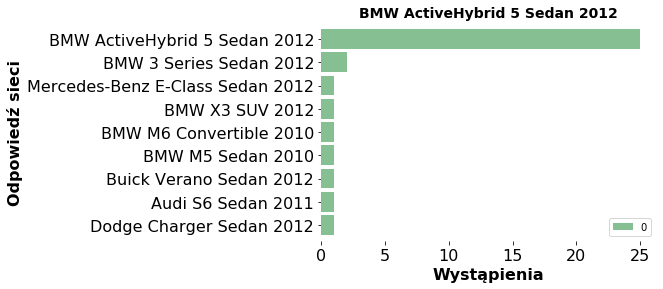

(73.52941176470588, 32.35294117647059, 0.0, [25, 5, 9, 0])

In [7]:
#(img_path, model, input_shape, class_names, input_shape, class_names, correct_class, show_imgs=True, top=5):
class_names = return_class_names_list(RESULTS_FOLDER)
common_brands = return_most_common_brands(class_names)
common_types = return_car_types(class_names)
#resize = False
# print(common_brands)
# print(common_types)


def predict_on_class(model, input_shape, class_names, 
                     common_brands, common_types, folder_path, resize=False, threshold=0.9999, 
                     show_plots=True, print_analysis=True, savepath=''):
    
    class_name = os.path.basename(folder_path)
#     print('\n\n')
#     printmd('**'+class_name+'**')
    class_name_brand = take_make_from_classname(class_name)
    class_name_cartype = take_cartype_from_classname(class_name)
#     print("Brand:", class_name_brand)
#     print("Type:", class_name_cartype)
#     print('\n')
    # verify popularity ===> boolean popular_cartype_or_brand = False
    n_correct_brand = None
    n_correct_brand_or_type = None # correct brand, but not necesserely model (fiat punto instead of fiat bravo)
    n_correct_type = None
    n_totally_incorrect = None
    
    
    if is_popular_brand(class_name, common_brands):
        n_correct_brand = 0
        n_correct_brand_or_type = 0
        n_totally_incorrect = 0
    else:
        print ("The brand of car is not a popular brand. Statistics concerning brand won't be provided.")
    if is_popular_type(class_name, common_types):
        n_correct_brand_or_type = 0
        n_totally_incorrect = 0
    else:
        print ("The type of car is not a popular type. Statistics concerning type won't be provided.")

    
    main_return_dict = {}
    n_correct_make_and_model = 0 # correctly predicted (the higher value the better)
    n_corrects_high_confidence = 0 # correctly predicted with high confidence (>= threshold) (higher = better)
    n_incorrect_high_confidence = 0 # predicted incorrectly but with hight confidence (lowet = better)
    n_all_samples = 0 # all test/valid samples
    # all vars below concerns only the first prediction

    #n_correct_brand = 0 # all correctly predicted brand: bmw, fiat, volvo etc 
    #n_correct_type = 0 # wagon, hatchback, sedan etc (correct type but not necesserely make&model) (higher = better)
    incorrect_predictions_high_confidence = [] # concerns only first prediction (top1)
    incorrect_predictions = [] # concerns only first prediction (top1)
    all_top1_predictions = []
    top5accuracy = 0
    
    # list for further analysis
    top5_predictions = [] # all top 5 pred for all samples without their confidences into list
    top5_predictions_high = [] # top 5 pred for all samples into list only with conf higher than 0.3
    
    # 3-5 NAJCZESCIEJ ZGADYWANE MARKI DLA MODELU
    # WYKRES TO POWYŻSZE PRZEDSTAWIAJĄCY
    for img in os.scandir(folder_path):
        n_all_samples+=1
        predictions = predict(os.path.abspath(img), model, input_shape, class_names, class_name, resize=resize, top=1, show_imgs=False)
        all_top1_predictions.append(predictions[0][0][0])
        if (predictions[0][0][0] == class_name):
            n_correct_make_and_model+=1
            if (float(predictions[0][0][1]) >= threshold):
                n_corrects_high_confidence+=1
        else:
            incorrect_predictions.append(predictions[0][0][0])
            if (float(predictions[0][0][1]) >= threshold):
                n_incorrect_high_confidence+=1
            if n_correct_brand is not None:
                if take_make_from_classname(predictions[0][0][0]) == class_name_brand:
                    n_correct_brand+=1
                    n_correct_brand_or_type+=1
                    #print(predictions[0][0][0])
                else:
                    if (n_correct_brand_or_type is not None) and (
                                                                take_cartype_from_classname(
                                                                predictions[0][0][0]) == class_name_cartype):
                        #print(predictions[0][0][0])
                        n_correct_brand_or_type+=1
            else:
                if (n_correct_brand_or_type is not None) and (
                                                                take_cartype_from_classname(
                                                                predictions[0][0][0]) == class_name_cartype):
                    #print(predictions[0][0][0])
                    n_correct_brand_or_type+=1
                        
        if n_correct_brand_or_type is not None:
            n_totally_incorrect = len(incorrect_predictions) - n_correct_brand_or_type
        else:
            n_correct_brand_or_type = len(incorrect_predictions)
            
#         for prediction in predictions[0]:
#             top5_predictions.append(prediction[0])
#             if (float(prediction[1]) >= 0.3):
#                 top5_predictions_high.append(prediction[0])
            # print(prediction[0])
    #print(top5_predictions)
    #print(incorrect_predictions)
    accuracy = n_correct_make_and_model/n_all_samples*100
    correctly_pred_high_conf_perc = n_corrects_high_confidence/n_all_samples*100
    incorrectly_pred_hih_conf_perc = n_incorrect_high_confidence/n_all_samples*100
    brand_type_analysis = [n_correct_make_and_model, 
                           n_correct_brand, n_correct_brand_or_type, n_totally_incorrect]
    
    #print(brand_type_analysis)
    if print_analysis:
        print("All samples: {}. Correctly predicted: {}. Accuracy: {}%.".format(n_all_samples,
                    n_correct_make_and_model,accuracy))
        print("Correctly predicted with high confidence: {} => {}% of all.".
              format(n_corrects_high_confidence,correctly_pred_high_conf_perc))
        print("Incorrectly predicted with high confidence: {} => {}% of all. ".
              format(n_incorrect_high_confidence,incorrectly_pred_hih_conf_perc))
        #print(brand_type_analysis)
    
    if show_plots:
        #mostcommon_predictions(top5_predictions, class_name+': '+'Most common top5 predictions',
                               #savepath=savepath)

        if n_correct_brand is not None:
            plot_prediction_analysis_all(brand_type_analysis)
            plot_prediction_analysis_brand(brand_type_analysis)
        else:
            if n_correct_brand_or_type is not None:
                plot_prediction_analysis_all(brand_type_analysis)
        
        mostcommon_predictions(all_top1_predictions, 
                                    class_name, many_data=False,
                                    savepath=savepath)
    
    #testing treashold
#     if (incorrectly_pred_hih_conf_perc > 0.0):
#         print(class_name + "\t" + str(incorrectly_pred_hih_conf_perc))
        
    return accuracy, correctly_pred_high_conf_perc, incorrectly_pred_hih_conf_perc, brand_type_analysis

# plot_model(loaded_model, to_file='model.svg', show_layr_names=True, show_shapes=True)
predict_on_class(loaded_model, input_shape, 
                 class_names, common_brands, common_types, 
                 TEST_DIR_TST + '/BMW ActiveHybrid 5 Sedan 2012', resize=resize, show_plots=True, print_analysis=False)

# predict_on_class(loaded_model, input_shape, 
#                  class_names, common_brands, common_types, 
#                  TEST_DIR_TST + '/Dodge Caliber Wagon 2012')


Creation of the directory ../saved_models/../saved_models/BEST_OF_THE_BEST/all_layers_trained_lhcbgpu_inceptionv3_RESIZEDIMGS/20190626_0944/resuls_analysis failed
The type of car is not a popular type. Statistics concerning type won't be provided.
The type of car is not a popular type. Statistics concerning type won't be provided.
The brand of car is not a popular brand. Statistics concerning brand won't be provided.
The type of car is not a popular type. Statistics concerning type won't be provided.
The type of car is not a popular type. Statistics concerning type won't be provided.
The type of car is not a popular type. Statistics concerning type won't be provided.
The type of car is not a popular type. Statistics concerning type won't be provided.
The brand of car is not a popular brand. Statistics concerning brand won't be provided.
The type of car is not a popular type. Statistics concerning type won't be provided.
The type of car is not a popular type. Statistics concerning type 

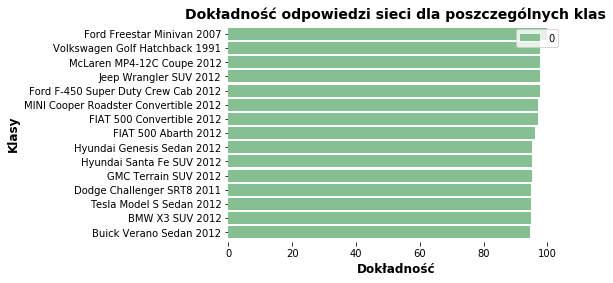

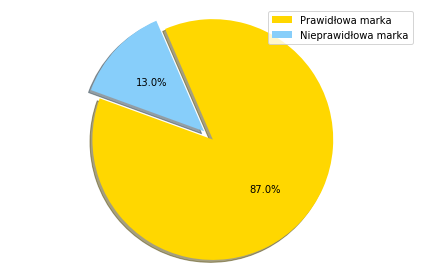

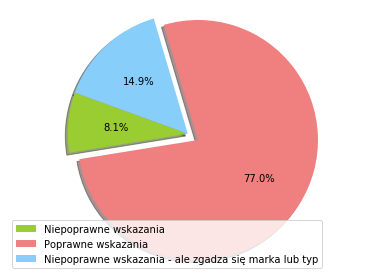

In [8]:
import collections
import itertools

class_names = return_class_names_list(RESULTS_FOLDER)
common_brands = return_most_common_brands(class_names)
common_types = return_car_types(class_names)

def create_folder_with_analysis(results_folder):
    # name of dir
    ANALYSIS_PATH = "../saved_models/" + results_folder + "/resuls_analysis"
    access_rights = 0o755
    try:  
        os.makedirs(ANALYSIS_PATH, access_rights)
    except OSError:  
        print ("Creation of the directory %s failed" % ANALYSIS_PATH)
    else:  
        print ("Successfully created the directory %s" % ANALYSIS_PATH)
    return ANALYSIS_PATH

def analyse_all_classes(loaded_model, results_folder, test_directory, resize=False):
    # create target folder
    ANALYSIS_PATH = create_folder_with_analysis(results_folder)
    general_acc_dict = {}
    incorrect_high_conf = {}
    brand_type_analysis_counter = [0,0,0,0]
    brand_analysis_counter = [0,0,0,0]
    if os.path.exists(ANALYSIS_PATH):
        for subfolder in os.scandir(test_directory):
            class_name_path = os.path.abspath(subfolder)
            results_for_class=predict_on_class(loaded_model, input_shape, class_names, 
                                                    common_brands, common_types, 
                                                    class_name_path, resize=resize, threshold=0.9999, 
                                                    print_analysis=False, show_plots=False, 
                                                    savepath=ANALYSIS_PATH)
            brand_type_an_oneclass = results_for_class[3]

            if brand_type_an_oneclass[1] is not None:
                for n in range(0,4):
                    brand_analysis_counter[n] = brand_analysis_counter[n] + brand_type_an_oneclass[n]
                    brand_type_analysis_counter[n] = brand_type_analysis_counter[n] + brand_type_an_oneclass[n]
            elif brand_type_an_oneclass[1] is None and brand_type_an_oneclass[2] is not None:
                for n in range(0,4):
                    if n != 1:
                        brand_type_analysis_counter[n] = brand_type_analysis_counter[n] + brand_type_an_oneclass[n]
            else:
                continue
            general_acc_dict[subfolder.name] = results_for_class[0]
            incorrect_high_conf[subfolder.name] = results_for_class[2]
#     # plot overall analysis of general accuracy
#     plot_accuracy_for_all_classes(general_acc_dict, title='Dokładność odpowiedzi sieci dla poszczególnych klas', 
#                                   fontsize=5, savepath='', many_data=False)
    # plot overall analysis of general accuracy for 15 best recognizable cars
    sorted_general_acc_dict = sorted(general_acc_dict.items(), key=lambda kv: kv[1], reverse=True)
    sorted_general_acc_Dict = collections.OrderedDict(sorted_general_acc_dict)
#     print(sorted_general_acc_Dict)
    sorted_general_acc_Dict_sliced = dict(itertools.islice(sorted_general_acc_Dict.items(), 15))
    plot_accuracy_for_all_classes(sorted_general_acc_Dict_sliced, title='Dokładność odpowiedzi sieci dla poszczególnych klas', 
                                  fontsize=5, savepath='', many_data=False)
    # plot overall analysis of incorrectly predicted
#     plot_accuracy_for_all_classes(incorrect_high_conf, 
#                                   title='Incorrect predictions with confidence', 
#                                   fontsize=5, savepath='', many_data=True)
    # plot overall analysis of correctly/incorrectly predicted due to brand
#     print(brand_analysis_counter)
    plot_prediction_analysis_brand(brand_analysis_counter)
    # plot overall analysis of correctly pred/correctly brand/cartype
    plot_prediction_analysis_all(brand_type_analysis_counter)

#TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_s/test'
analyse_all_classes(loaded_model, RESULTS_FOLDER,TEST_DIR_TST, resize=resize)





In [18]:
import collections
import itertools
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(x.items(), key=lambda kv: kv[1])
sorted_dict = collections.OrderedDict(sorted_x)

sorted_sliced = dict(itertools.islice(sorted_dict.items(), 2))
sorted_sliced

{0: 0, 2: 1}

In [17]:
import collections
import itertools
x = {'a': 2, 'b': 4, 'd': 3, 'c': 1, 'e': 0}
sorted_x = sorted(x.items(), key=lambda kv: kv[1], reverse=True)
sorted_dict = collections.OrderedDict(sorted_x)

sorted_sliced = dict(itertools.islice(sorted_dict.items(), 6))
dict(sorted_sliced)

{'b': 4, 'd': 3, 'a': 2, 'c': 1, 'e': 0}

In [15]:
show_model_performance(loaded_model, generator_train, generator_test)

KeyboardInterrupt: 

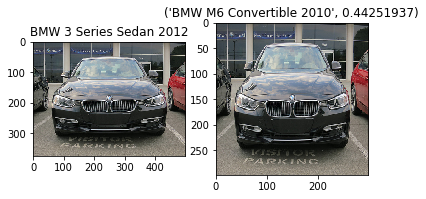

[[('BMW M6 Convertible 2010', 0.44251937), ('BMW M5 Sedan 2010', 0.25168598), ('BMW 3 Series Sedan 2012', 0.22602141), ('BMW Z4 Convertible 2012', 0.014173075), ('BMW 6 Series Convertible 2007', 0.011936047)]]


In [36]:
perform_pred(loaded_model, resize=False, car_class='BMW 3 Series Sedan 2012')


In [29]:
def load_image(img_path, input_shape, resize = False):
    if resize:
        img, pth = resize_black(input_shape[1], img_path, print_oldsize=False)
    else:
        img = image.load_img(img_path, target_size=input_shape)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    #print(type(img_tensor))
    return img_tensor


load_image('/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test/MINI Cooper Roadster Convertible 2012/00725.jpg',
          (299,299), resize=True)

<class 'numpy.ndarray'>


array([[[[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        ..., 
        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0.],
  

In [ ]:
#img_pth = '../test_imgs/mercs.jpg'
#img_pth=TEST_DIR_TST+'/'+'/BMW 3 Series Sedan 2012'+'/01631.jpg')
#def perform_pred(loaded_model, resize=False, car_class=None, img_pth=None, show_imgs=True)
'/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test/MINI Cooper Roadster Convertible 2012/00725.jpg'